# A regression Example - Predicting house prices

In [33]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()


In [34]:
train_data.shape

(404, 13)

In [35]:
test_data.shape

(102, 13)

In [36]:
train_targets


array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

# Preparing the data

In [37]:
import numpy as np

In [38]:
##process --> Best practice is to do feature-wise normalization
## This involves for every feature column, subtract the mean of the feature and divide the result be the standard
## deviation. This ensures that the feature is centered around 0 and has a unit standard deviation. 
## Note that the quantities used for normalizing the test data are computed using the training data.

In [39]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

# Training the network


In [40]:
## since there is few samples available, we shall use a very small network, i.e 2 hidden layers with 64 units each. 
## Rem: The less training samples you have, the more susceptible you are to overfitting and using smaller networks 
## is one way to curb the overfitting problem.

In [41]:
from keras import models
from keras import layers

In [42]:
def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer = 'rmsprop', loss='mse', metrics=['mae'])
    return model

# Validation


In [43]:
## Since our dataset is small, we shall use K-fold cross validation procedure. 
## We split our dataset into k-partitions (typically K = 4 or 5), instantiating K identical models, and training 
## each one on K-1 partitions while evaluating on the remaining partition
## The validation score for the model used is then the average of the K validation scores obtained.

In [44]:
import numpy as np
k = 4
num_val_samples = len(train_data)//k
num_epochs = 500
all_mae_histories = []
all_scores = []


In [45]:
## prepare the validation data: data from partition #k
for i in range(k):
    print('Processing the fold #', i)
    val_data = train_data[i * num_val_samples:(i + 1)*num_val_samples]
    val_targets = train_targets[i * num_val_samples:(i + 1)* num_val_samples]
    partial_train_data = np.concatenate([train_data[:i * num_val_samples], train_data[(i + 1) * num_val_samples:]],
                                       axis = 0)
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples], 
                                            train_targets[(i + 1) * num_val_samples:]], axis = 0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, validation_data=(val_data, val_targets),
                        epochs = num_epochs, batch_size = 1, verbose = 0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose = 0)
    mae_history = history.history['mae']
    all_mae_histories.append(mae_history)
    all_scores.append(val_mae) 
    
    
    

Processing the fold # 0
Processing the fold # 1
Processing the fold # 2
Processing the fold # 3


In [46]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

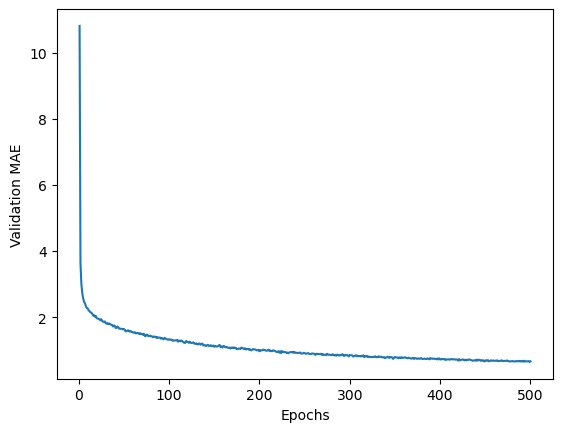

In [48]:
## Plotting validation scores
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [ ]:
def smooth_curve(points, factor = 0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous  = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()